In [1]:
from collections import OrderedDict
from pprint import pprint
from tqdm import trange

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import BorderlineSMOTE
from hypopt import GridSearch  # provide posibility for search with validation set

import utils
from data_preprocess import preprocess_fifa_data
from estimators import Estimator
from experiment import perform_grid_search, eval_model
import static

from feature_engineer import (
    make_card_features,
    make_card_features_with_pca,
    transform_data,
    transofrm_skils
)

In [2]:
# disable sklearn warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
decision_tree_params = {
    'max_depth': [5,6,7],
    'min_samples_leaf': [20],
    'min_samples_split' : [100],
    'max_features': ['sqrt']
}

estimators = [
    Estimator(
        name='DecisionTreeClassifier',
        estimator=DecisionTreeClassifier(),
        param_grid={
            **decision_tree_params,
            'splitter': ['best', 'random']
        }
    ),
    Estimator(
        name='RandomForestClassifier',
        estimator=RandomForestClassifier(),
        param_grid={
             **decision_tree_params,
            'bootstrap': [True],
            'n_estimators': [100, 500, 1000]
        }
    ),
    Estimator(
        name='GradientBoostingClassifier',
        estimator=GradientBoostingClassifier(),
        param_grid={
            **decision_tree_params,
            'n_estimators': [100, 200, 500, 1000],
            'subsample': [1, 0.8]
        }
    ), 
    Estimator(
        name='XGBClassifier',
        estimator=xgb.XGBClassifier(),
        param_grid={
            'objective': ['multi:softmax'],
            'num_class': [7],
            'n_estimators': [100, 200, 500, 1000],
            'subsample': [1, 0.8]
        }
    ), 
    Estimator(
        name='AdaBoostClassifier',
        estimator=AdaBoostClassifier(),
        param_grid={
            'n_estimators': [100, 200, 500, 1000]
        }
    ),
    Estimator(
        name='KNeighborsClassifier',
        estimator=KNeighborsClassifier(),
        param_grid={
            'n_neighbors': [5,10,20,30,50]
        }
    ),
    Estimator(
        name='MLPClassifier',
        estimator=MLPClassifier(),
        param_grid={
            'hidden_layer_sizes': [(30,), (40,), (50,)],
            'max_iter': [200, 500, 1000],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive'],
        }
    ),
]

In [4]:
def run_experiemnt(data, estimators):
    grid_search_args = {'num_threads': 2}
    return {estimator.name: perform_grid_search(data, estimator, grid_search_args) for estimator in estimators}

def experiment_with_data_transform(
    transform_type='no_transform', 
    target_type='default', 
    do_oversampling=False, 
    selector=None,
    sampler=None
):    
    fifa_data = utils.get_fifa_data(target_type=target_type)
    fifa_data = transform_data(fifa_data, transform_type)
    fifa_data = transofrm_skils(fifa_data)
    learning_data = utils.setup_learning_data(fifa_data)
    learning_data = utils.oversampling(learning_data, sampler) if do_oversampling else learning_data
    learning_data = utils.select_features(selector, learning_data) if selector else learning_data
    scores = run_experiemnt(learning_data, estimators)
    utils.plot_experiment_result(scores, transform_type)

INFO:data_prepare_pipeline:run data preparation pipeline
INFO:data_prepare_pipeline:droping columns
INFO:data_prepare_pipeline:droping records with nan values
INFO:data_prepare_pipeline:droping goalkeepers
INFO:data_prepare_pipeline:transform data
INFO:data_prepare_pipeline:transform column Body Type
INFO:data_prepare_pipeline:transform column Height
INFO:data_prepare_pipeline:transform column Weight
INFO:data_prepare_pipeline:transform column LS
INFO:data_prepare_pipeline:transform column ST
INFO:data_prepare_pipeline:transform column RS
INFO:data_prepare_pipeline:transform column LW
INFO:data_prepare_pipeline:transform column LF
INFO:data_prepare_pipeline:transform column CF
INFO:data_prepare_pipeline:transform column RF
INFO:data_prepare_pipeline:transform column RW
INFO:data_prepare_pipeline:transform column LAM
INFO:data_prepare_pipeline:transform column CAM
INFO:data_prepare_pipeline:transform column RAM
INFO:data_prepare_pipeline:transform column LM
INFO:data_prepare_pipeline:tr

shape before preprocess (16122, 65)
Dropping constant columns: []
Label encoding
Preferred Foot encoding:
{'Left': 0, 'Right': 1}
Work Rate encoding:
{'High/ High': 0,
 'High/ Low': 1,
 'High/ Medium': 2,
 'Low/ High': 3,
 'Low/ Low': 4,
 'Low/ Medium': 5,
 'Medium/ High': 6,
 'Medium/ Low': 7,
 'Medium/ Medium': 8}
Body Type encoding:
{'Lean': 0, 'Normal': 1, 'Stocky': 2}
Position encoding:
{'B': 0, 'F': 1, 'M': 2}
Filtering players by overall 70
shape after preprocess (5137, 65)
dropped 10985 rows
dropped 0 columns
Data transform: card_features_pca
Columns after transform
Index(['Age', 'Overall', 'Potential', 'Preferred Foot', 'Weak Foot',
       'Work Rate', 'Body Type', 'Position', 'Height', 'Weight', 'LS', 'ST',
       'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
       'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB',
       'RCB', 'RB', 'Composure', 'Pace', 'Shooting', 'Passing', 'Dribbling',
       'Deffending', 'Physical'],
     

100%|██████████| 6/6 [00:00<00:00, 314.02it/s]

DecisionTreeClassifier results
Best estimator params: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 100, 'splitter': 'best'}
Best estimator score: 0.7444795383158085
running GridSearch for RandomForestClassifier



100%|██████████| 9/9 [00:11<00:00,  1.28s/it]


RandomForestClassifier results
Best estimator params: {'bootstrap': True, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 100, 'n_estimators': 500}
Best estimator score: 0.7835260371175135
running GridSearch for GradientBoostingClassifier


100%|██████████| 24/24 [01:00<00:00,  2.50s/it]


GradientBoostingClassifier results
Best estimator params: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 100, 'n_estimators': 1000, 'subsample': 0.8}
Best estimator score: 0.8414928094367189
running GridSearch for XGBClassifier


100%|██████████| 8/8 [00:21<00:00,  2.72s/it]


XGBClassifier results
Best estimator params: {'n_estimators': 500, 'num_class': 7, 'objective': 'multi:softmax', 'subsample': 0.8}
Best estimator score: 0.840100691596026
running GridSearch for AdaBoostClassifier


100%|██████████| 4/4 [00:08<00:00,  2.18s/it]


AdaBoostClassifier results
Best estimator params: {'n_estimators': 500}
Best estimator score: 0.6886332648084026
running GridSearch for KNeighborsClassifier


100%|██████████| 5/5 [00:00<00:00, 14.10it/s]


KNeighborsClassifier results
Best estimator params: {'n_neighbors': 20}
Best estimator score: 0.7141503818612474
running GridSearch for MLPClassifier


100%|██████████| 72/72 [03:10<00:00,  2.65s/it]


MLPClassifier results
Best estimator params: {'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'adam'}
Best estimator score: 0.8455490959188356


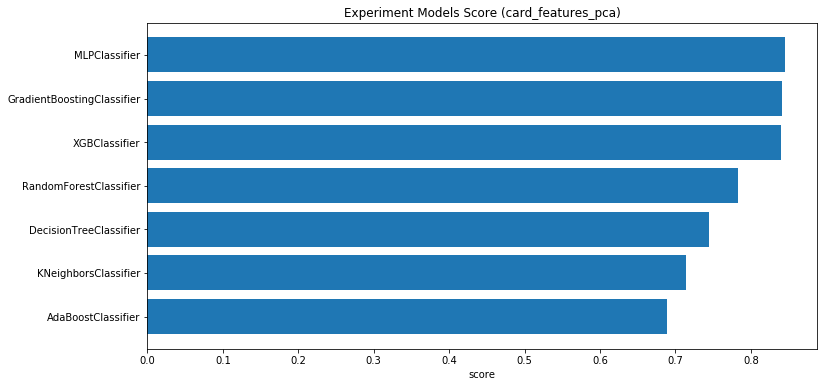

In [5]:
experiment_with_data_transform(
    transform_type='card_features_pca',
    target_type='3_classes',
    do_oversampling=True,
    sampler=BorderlineSMOTE(),
    selector= RFECV(RandomForestClassifier(n_estimators=100), cv=5, step=1, n_jobs=4, verbose=5)
)